<a href="https://colab.research.google.com/github/srivatsa-kundurthy/PINNs/blob/main/PINN_for_MNIST_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://github.com/amitrajitbose/handwritten-digit-recognition/blob/master/handwritten_digit_recognition_CPU.ipynb
#https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627
!pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=431ff5beee4e5b2039adc5e2ab735944986cdc05ee1e0e55ce9d61ee4c772156
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


In [ ]:
#imports
# Import necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import random
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
import os
from google.colab import drive
from torchvision import datasets, transforms
from torch import nn
from torch import optim


import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split


#from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

In [ ]:
# SEED
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

# MNIST

In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=True, transform=transform)
valset = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True) # change batch size to 128 from 64
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [ ]:
#output test
#print(len(list(trainloader)))
#batch count

In [ ]:
# define the MNIST model
# Layer details for the neural network
input_size = 784
hidden_sizes =[10,10] #[1,1]#[10,10] #[128, 64]
num_weights = np.prod(hidden_sizes)
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)


Sequential(
  (0): Linear(in_features=784, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [ ]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images)
loss = criterion(logps, labels)

In [ ]:

# Optimizers require the parameters to optimize and a learning rate
MNIST_optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# PINN SETUP

In [ ]:
#PINN model
#TODO define c
c = 1 #heuristic

f_collection = []
f_t_collection = []
f_x_collection = []
f_xx_collection = []
class PINN(nn.Module):


    # Class variables
    
    # gradient tracking

   
  #https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main/PyTorch/Burgers'%20Equation
    ##Neural Network
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0 #For the Optimizer
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    'Loss Functions'
    #Loss BC
    def lossBC(self,x_BC,y_BC):
      loss_BC=self.loss_function(self.forward(x_BC),y_BC)
    
      return loss_BC
    #Loss PDE
    def lossPDE(self,x_PDE):
      g=x_PDE.clone()
     # g.requires_grad=True #Enable differentiation #TODO REVIEW
      g.retain_grad()
      f=self.forward(g)
      f_x_t = autograd.grad(f,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
      f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape).to(device), create_graph=True)[0]#second derivative
      f_t=f_x_t[:,[1]]# we select the 2nd element for t (the first one is x) (Remember the input X=[x,t]) 
      f_xx=f_xx_tt[:,[0]]# we select the 1st element for x (the second one is t) (Remember the input X=[x,t]) 
      f_x=f_x_t[:,[0]]
      f= -f_t + f_x + f_xx - c

      #collections
      f_collection.append(f)
      f_t_collection.append(-f_t) # note -f_t
      f_x_collection.append(f_x)
      f_xx_collection.append(f_xx)

      return self.loss_function(f,f_hat)

    def loss(self,x_BC,y_BC,x_PDE):
      loss_bc=self.lossBC(x_BC,y_BC)

      loss_pde=self.lossPDE(x_PDE)
      return loss_bc+loss_pde

    #Optimizer              X_train_Nu,Y_train_Nu,X_train_Nf                   
    def closure(self):
      PINN_optimizer.zero_grad()  
      loss = self.loss(X_train_Nu,Y_train_Nu,X_train_Nf)
      loss.backward()      
      self.iter += 1
      if self.iter % 100 == 0:
        loss2=self.lossBC(X_test,Y_test)
        print("Training Error:",loss.detach().cpu().numpy(),"---Testing Error:",loss2.detach().cpu().numpy())
      return loss

    def plot(data, steps):
      pass
      

In [ ]:
#learning params
steps=300 # 1000
lr=1e-3
layers = np.array([2,32,32,1]) # hidden layers
# To generate new data:
#x_min=-1
#x_max=1
#t_min=0
#t_max=1
#total_points_x=200
#total_points_t=100
#Nu: Number of training points # Nf: Number of collocation points (Evaluate PDE)
#Nu=100
#Nf=10000

In [ ]:
# PINN training on device
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 


cpu


In [ ]:
#compact PINN training method
pinn_loss_graph = []
mnist_loss_graph = []
def trainPINN(X_train,Y_train,collocation,act_loss):
  for i in range(steps):
    if i==0:
      print("Training Loss-----Test Loss")
    loss = PINN_model.loss(X_train,Y_train,collocation)# use mean squared error
    PINN_optimizer.zero_grad()
    loss.backward()
    PINN_optimizer.step()
    if i%(steps/10)==0:
      #with torch.no_grad():
       # test_loss=PINN.lossBC(X_test,Y_test)
      print("--------------------------PINN STEP--------------------------")
      print('#',i)
      print('PINN SELF LOSS COMPUTATION:',loss.detach().cpu().numpy(),'---')#,test_loss.detach().cpu().numpy())
      #print('PINN PREDICTION OF MNIST LOSS',PINN_model.forward(X_train))
      print('MNIST GROUND TRUTH LOSS:', act_loss)
      print('PINN AVG. PREDICTION OF MNIST LOSS:',torch.mean(PINN_model.forward(X_train)))
    pinn_loss_graph.append(torch.mean(PINN_model.forward(X_train)).detach().numpy())
    mnist_loss_graph.append(act_loss)
     

# Training

In [ ]:
#MNIST training


# RERUN PINN SETUP TO RESET COLLECTIONS
MNIST_optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 1
iteration_bound=0
for e in range(epochs):
    running_loss = 0
    
    weight_train = [] # all weights, used for collocation
    collocation = []
    iter_weights = [] # store 8192 weights per iteration
    idx_mat = [] # zeroes mat + n
    iter_loss = 0
    #idx=np.random.choice(X_train.shape[0],Nu,replace=False) # train
    for images, labels in trainloader:
        iteration_bound+=1
        if iteration_bound>10: #limit training to 10 iterations to view trends in short term
          break
          # save our needed figs here
          plt.plot(f_collection,label='1')
          plt.legend()
          plt.show()

          break
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        MNIST_optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #backprop
        loss.backward()
        
        #update weights
        MNIST_optimizer.step()
       
        running_loss += loss.item()
        print('--------------------------MNIST TRAINING ITERATION--------------------------')
        print('Iteration {} - Training loss: {}'.format(iteration_bound,running_loss/len(trainloader)))
        #print('weight mat', model[2].weight[0])
        
        # Collect data for PINN
        iter_weights.append(model[2].weight)
        idx_mat = torch.zeros((num_weights,1)) + iteration_bound

        #print('weight mat',torch.flatten(model[2].weight).unsqueeze(1))
        #print('idx_mat',idx_mat)

        weight_train = torch.hstack(( (torch.flatten(model[2].weight).unsqueeze(1)), idx_mat))
        iter_loss = running_loss/len(trainloader)
        f_hat = torch.zeros(weight_train.shape[0],1)

        #print('weight mat',torch.flatten(model[2].weight).shape())
        #print('idx_mat',idx_mat.shape())

        weight_train=weight_train.float().to(device)#Training Points (BC)
        iter_loss=torch.Tensor([iter_loss]).float().to(device)#Training Points (BC)
        weight_train=weight_train.float().to(device)#Collocation Points
        f_hat = f_hat.to(device)#to minimize function

        # build PINN model
        PINN_model = PINN(layers)
        PINN_model.to(device)

        params = list(PINN_model.parameters())
        PINN_optimizer = torch.optim.Adam(PINN_model.parameters(),lr=lr,amsgrad=False)
        
        if iteration_bound != 1:
          # loading from training checkpoint
          checkpoint = torch.load(PATH)
          PINN_model.load_state_dict(checkpoint['model_state_dict'])
          PINN_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        # Train PINN
        trainPINN(weight_train,iter_loss,weight_train,running_loss/len(trainloader))
        
        # saving model checkpoint
        PATH = 'results' + str(iteration_bound) + '.pth'

        torch.save({
            'model_state_dict': PINN_model.state_dict(),
            'optimizer_state_dict': PINN_optimizer.state_dict(),
            }, PATH)
        print('--------------------------SAVED PINN CHECKPOINT--------------------------')
        print('Checkpoint #', str(iteration_bound))

       
          

    else:
        print("Epoch {} - Training loss: {}".format(e+1, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)
#iteration_bound-=1 # get the print right for file saves later

--------------------------MNIST TRAINING ITERATION--------------------------
Iteration 1 - Training loss: 0.005029643268219189
Training Loss-----Test Loss
--------------------------PINN STEP--------------------------
# 0
PINN SELF LOSS COMPUTATION: 1.0477107 ---
MNIST GROUND TRUTH LOSS: 0.005029643268219189
PINN AVG. PREDICTION OF MNIST LOSS: tensor(-0.0968, grad_fn=<MeanBackward0>)
--------------------------PINN STEP--------------------------
# 30
PINN SELF LOSS COMPUTATION: 0.021781992 ---
MNIST GROUND TRUTH LOSS: 0.005029643268219189
PINN AVG. PREDICTION OF MNIST LOSS: tensor(0.0507, grad_fn=<MeanBackward0>)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------------PINN STEP--------------------------
# 60
PINN SELF LOSS COMPUTATION: 0.01723863 ---
MNIST GROUND TRUTH LOSS: 0.005029643268219189
PINN AVG. PREDICTION OF MNIST LOSS: tensor(-0.0132, grad_fn=<MeanBackward0>)
--------------------------PINN STEP--------------------------
# 90
PINN SELF LOSS COMPUTATION: 0.014866432 ---
MNIST GROUND TRUTH LOSS: 0.005029643268219189
PINN AVG. PREDICTION OF MNIST LOSS: tensor(-0.0020, grad_fn=<MeanBackward0>)
--------------------------PINN STEP--------------------------
# 120
PINN SELF LOSS COMPUTATION: 0.012704271 ---
MNIST GROUND TRUTH LOSS: 0.005029643268219189
PINN AVG. PREDICTION OF MNIST LOSS: tensor(-0.0043, grad_fn=<MeanBackward0>)
--------------------------PINN STEP--------------------------
# 150
PINN SELF LOSS COMPUTATION: 0.010737406 ---
MNIST GROUND TRUTH LOSS: 0.005029643268219189
PINN AVG. PREDICTION OF MNIST LOSS: tensor(-0.0026, grad_fn=<MeanBackward0>)
--------------------------PINN STEP--------------------------
#

[array(-0.09684084, dtype=float32), array(-0.12572335, dtype=float32), array(-0.15303737, dtype=float32), array(-0.17870556, dtype=float32), array(-0.20251794, dtype=float32), array(-0.22429506, dtype=float32), array(-0.24383686, dtype=float32), array(-0.2608923, dtype=float32), array(-0.27518344, dtype=float32), array(-0.28643605, dtype=float32), array(-0.2944051, dtype=float32), array(-0.2988979, dtype=float32), array(-0.29979226, dtype=float32), array(-0.29704657, dtype=float32), array(-0.29070264, dtype=float32), array(-0.28088313, dtype=float32), array(-0.26778504, dtype=float32), array(-0.25166997, dtype=float32), array(-0.23285393, dtype=float32), array(-0.2116967, dtype=float32), array(-0.18859361, dtype=float32), array(-0.16396761, dtype=float32), array(-0.13826372, dtype=float32), array(-0.11194305, dtype=float32), array(-0.08547731, dtype=float32), array(-0.05934211, dtype=float32), array(-0.03400888, dtype=float32), array(-0.00993417, dtype=float32), array(0.01245274, dtype

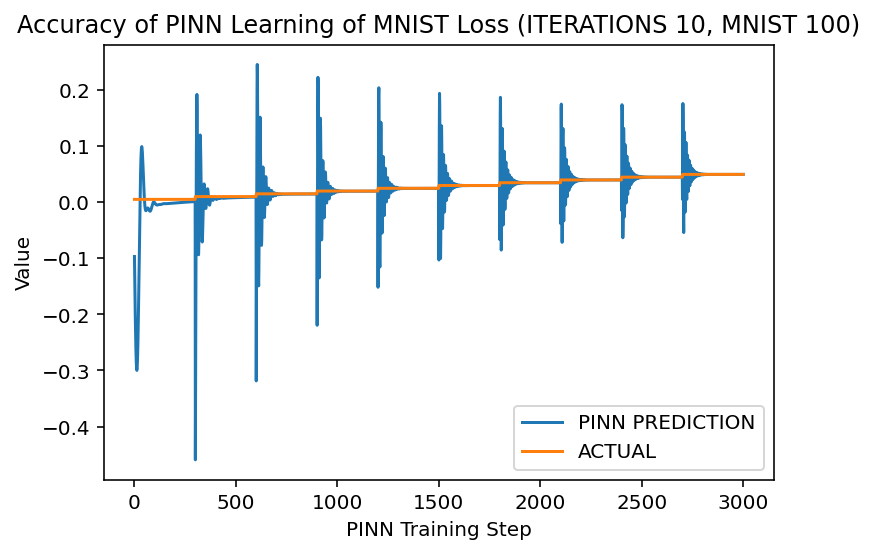

3000


In [ ]:
# pinn vs actual loss
print(pinn_loss_graph)
plt.plot(pinn_loss_graph,label='PINN PREDICTION')
plt.plot(mnist_loss_graph,label='ACTUAL')
plt.legend()
plt.xlabel('PINN Training Step')
plt.ylabel('Value')
plt.title(f'Accuracy of PINN Learning of MNIST Loss (ITERATIONS {iteration_bound-1}, MNIST {num_weights})')
plt.savefig(f'{len(f_collection[0])}_PINN_Accuracy.png')
plt.show()
print(len(pinn_loss_graph))

In [ ]:
# COLLECTIONS
print(len(f_collection[2]))

100


In [ ]:
def processCollection(collection,weight_index):
  """
  outputs a list of collection WRT one weight

  Takes as input one of the collections - a list of tensors. length of list is number of iterations ran, number of (float) objects in each tensor is the number of weights

  To get progression of one weight we pull the respective index from each tensor contained within the list through this method
  """

  temp = []
  for i in range(len(collection)):
    temp.append(collection[i][weight_index].detach().numpy()[0])
  print(temp)
  return temp


[-1.0649518, -0.9918922, -0.9193335, -0.847449, -0.77647185, -0.7066622, -0.6382923, -0.57166904, -0.507139, -0.44508266, -0.38589752, -0.32998002, -0.2777058, -0.22940874, -0.18536586, -0.14578253, -0.11078483, -0.080414236, -0.05462843, -0.033303678, -0.01624322, -0.003181696, 0.0062036514, 0.012287855, 0.015485525, 0.016244888, 0.015034199, 0.012333155, 0.008617997, 0.0043491125, -4.4703484e-05, -0.0041801333, -0.0077341795, -0.010454357, -0.012166917, -0.012777209, -0.012269497, -0.01069814, -0.008179069, -0.0048781633, -0.0009973645, 0.003236413, 0.0075848103, 0.011809468, 0.015683651, 0.019000888, 0.021583915, 0.023292303, 0.024025083, 0.023725986, 0.02238226, 0.0200243, 0.01672113, 0.012577057, 0.0077244043, 0.0023175478, -0.0034749508, -0.009477317, -0.015513897, -0.021415532, -0.027025044, -0.032203794, -0.0368343, -0.040823877, -0.044106603, -0.046643913, -0.0484246, -0.049462855, -0.04979676, -0.04948449, -0.048601925, -0.04723692, -0.045487046, -0.043453813, -0.041238964, -

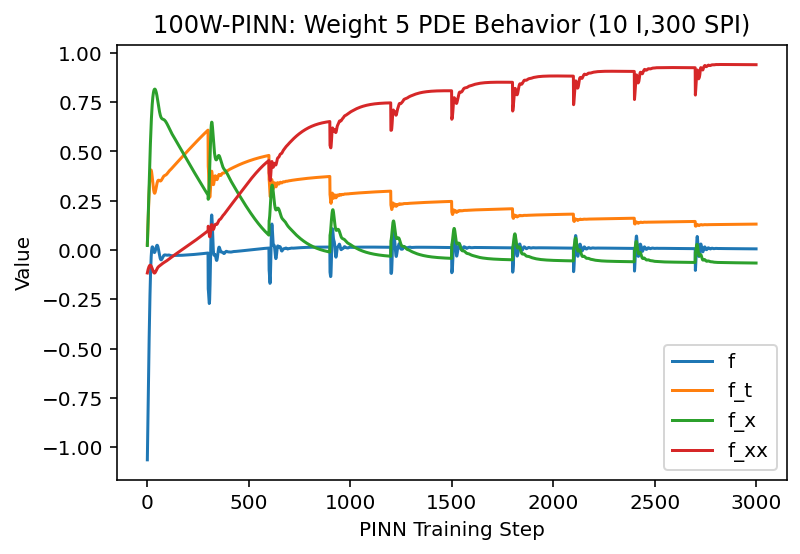

In [ ]:
# Single weight full PDE Comparison
def singleWeightTermPlot(w,iterations, steps,saveFig=False):
  f = processCollection(f_collection,w)
  f_t = processCollection(f_t_collection,w)
  f_x = processCollection(f_x_collection,w)
  f_xx = processCollection(f_xx_collection,w)
  plt.plot(f,label='f')
  plt.plot(f_t,label='f_t')
  plt.plot(f_x,label='f_x')
  plt.plot(f_xx,label='f_xx')
  plt.xlabel('PINN Training Step')
  plt.ylabel('Value')
  plt.title(f'{len(f_collection[0])}W-PINN: Weight {w} PDE Behavior ({iterations} I,{steps} SPI)')
  plt.legend()
  if saveFig==True:
    plt.savefig(f'{len(f_collection[0])}W-PINN_Weight_{w}_PDE_Behavior_({iterations}_I,{steps}_SPI).png')
  plt.plot()

singleWeightTermPlot(5,iteration_bound-1,steps,saveFig=True)

In [ ]:
def collectionWeightSample(collection,n_samples):
  """
  processCollection for randomly selected weights

  temp is the weight values
  vals is the weight index requested
  """
  random.seed(123456754)
  vals = random.sample(range(0,len(collection[0]-1)),n_samples)
  temp = [] 
  # list of returned from processCollection
  for val in vals:
    temp.append(processCollection(collection,val))
  
  #print(temp)
  return [temp,vals]



[-0.9767975, -0.90626526, -0.8361805, -0.76677024, -0.69826937, -0.630942, -0.56506944, -0.5009676, -0.4389916, -0.37952822, -0.32298034, -0.2697487, -0.22021323, -0.17471081, -0.13351834, -0.09683776, -0.06478757, -0.03739655, -0.01460588, 0.003727436, 0.017823815, 0.02797103, 0.034517765, 0.037861586, 0.038441658, 0.036726832, 0.033206105, 0.028375626, 0.022726774, 0.01673162, 0.010828137, 0.005403757, 0.00078368187, -0.0027817488, -0.005123794, -0.006156385, -0.0058739185, -0.00434345, -0.0016950369, 0.0018903017, 0.00619483, 0.010974646, 0.015974402, 0.020938873, 0.025622845, 0.029803514, 0.033287287, 0.03591764, 0.037579656, 0.038204074, 0.03776765, 0.036290765, 0.03383553, 0.030500531, 0.02641499, 0.021730423, 0.016614199, 0.011242986, 0.0057929754, 0.00043547153, -0.0046708584, -0.009384751, -0.013585985, -0.017179906, -0.020097852, -0.022298872, -0.023769915, -0.024523258, -0.024595082, -0.024042428, -0.022939563, -0.021373868, -0.019441485, -0.01724255, -0.01487869, -0.0124461

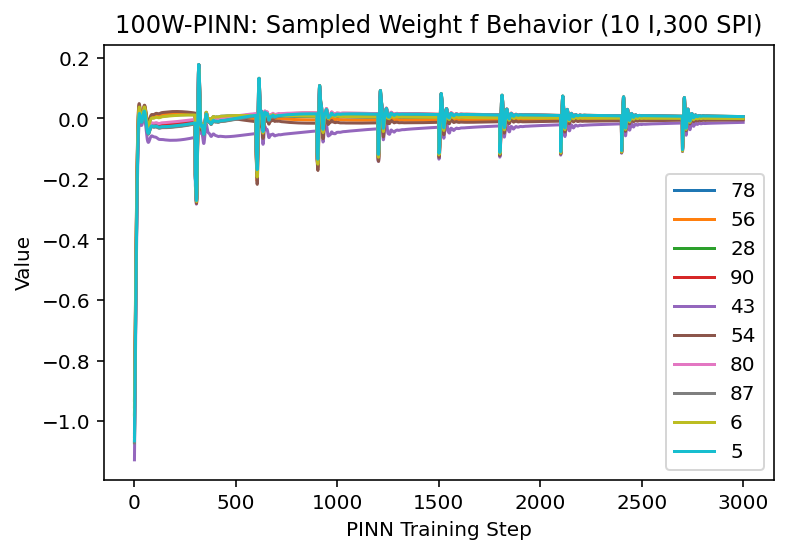

In [ ]:
# multiWeight single Collection comparison
def multiWeightComparisonPlot(collection, collection_name, n_samples,iterations,steps,saveFig=False):
  selected_function_progression = collectionWeightSample(collection,n_samples)
  i = 0
  for func in selected_function_progression[0]:
    plt.plot(func,label=selected_function_progression[1][i])
    i+=1

  plt.xlabel('PINN Training Step')
  plt.ylabel('Value')
  plt.title(f'{len(collection[0])}W-PINN: Sampled Weight {collection_name} Behavior ({iterations} I,{steps} SPI)')

  plt.legend()
  if saveFig == True:

    plt.savefig(f'{len(collection[0])}W-PINN_Sampled_Weight_{collection_name}_Behavior_({iterations}_I,{steps}_SPI).png')
  plt.show()

#####################################################
collection_name = 'f'
n_samples=10
multiWeightComparisonPlot(f_collection,collection_name, n_samples,iteration_bound-1,steps,saveFig=True)

# Misc. Testing (Archive)

In [ ]:
#size testing
import numpy as np

V = np.zeros((8192,1)) + 4
K = np.zeros((8192,1))
Z = np.hstack((V,K))
print(Z)

[[4. 0.]
 [4. 0.]
 [4. 0.]
 ...
 [4. 0.]
 [4. 0.]
 [4. 0.]]


<class 'list'>


[]

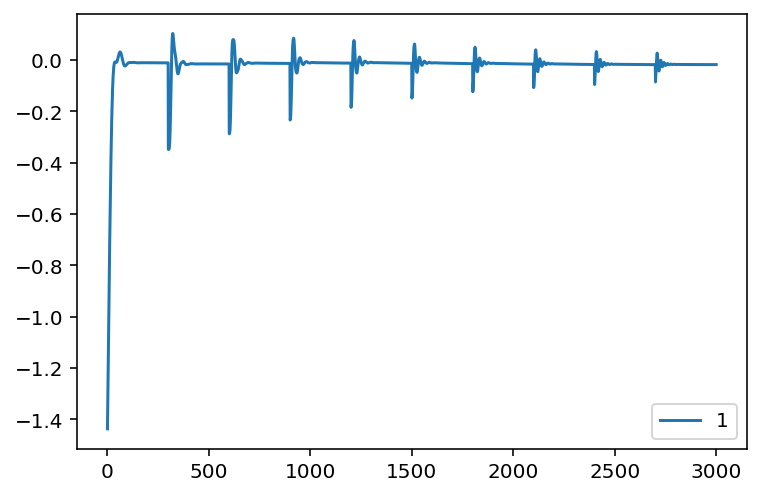

In [ ]:
#TESTING SKIP
# sampling of function collection
print(type(f_collection))
#print(f_collection.detach().numpy())
#print(f_collection)
# below example grabs all the calculated function values WRT just one weight
temp = []
for i in range(len(f_collection)):
  #print(f_collection[i][0].detach().numpy()[0])
  temp.append(f_collection[i][0].detach().numpy()[0])

plt.plot(temp,label='1')
plt.legend()
plt.plot()

<class 'list'>


[]

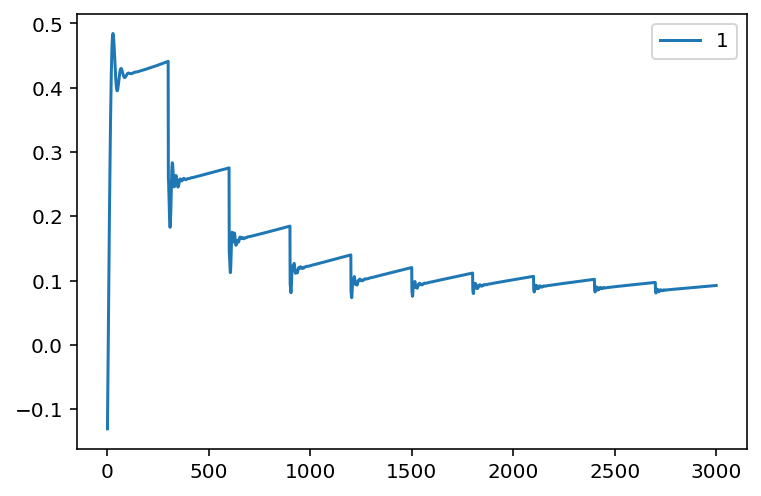

In [ ]:
# TESTING SKIP
# sampling of function collection
print(type(f_t_collection))
#print(f_collection.detach().numpy())
#print(f_collection)
# below example grabs all the calculated function values WRT just one weight
temp = []
for i in range(len(f_t_collection)):
  #print(f_collection[i][0].detach().numpy()[0])
  temp.append(f_t_collection[i][0].detach().numpy()[0])

plt.plot(temp,label='1')
plt.legend()
plt.plot()

[]

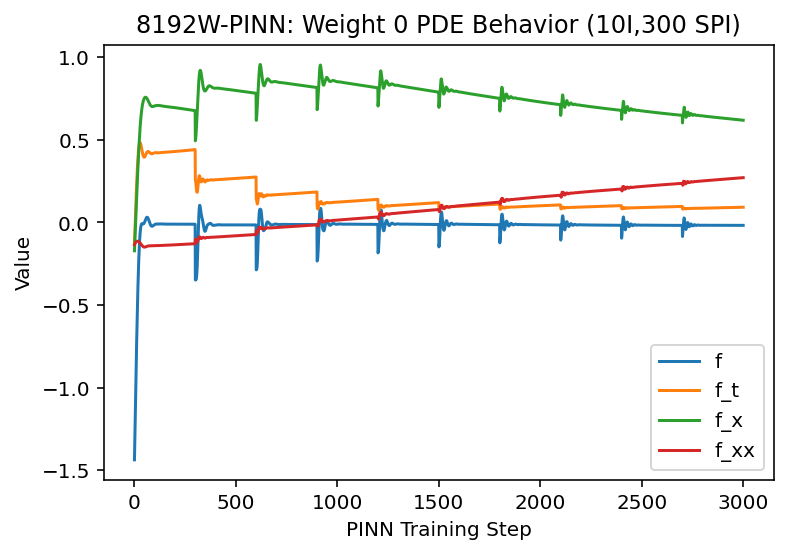

In [ ]:
"""
f_collection = []
f_t_collection = []
f_x_collection = []
f_xx_collection = []
"""
w = 0
f = processCollection(f_collection,w)
f_t = processCollection(f_t_collection,w)
f_x = processCollection(f_x_collection,w)
f_xx = processCollection(f_xx_collection,w)
plt.plot(f,label='f')
plt.plot(f_t,label='f_t')
plt.plot(f_x,label='f_x')
plt.plot(f_xx,label='f_xx')
plt.xlabel('PINN Training Step')
plt.ylabel('Value')
plt.title(f'8192W-PINN: Weight {w} PDE Behavior (10I,300 SPI)')
plt.legend()
plt.plot()

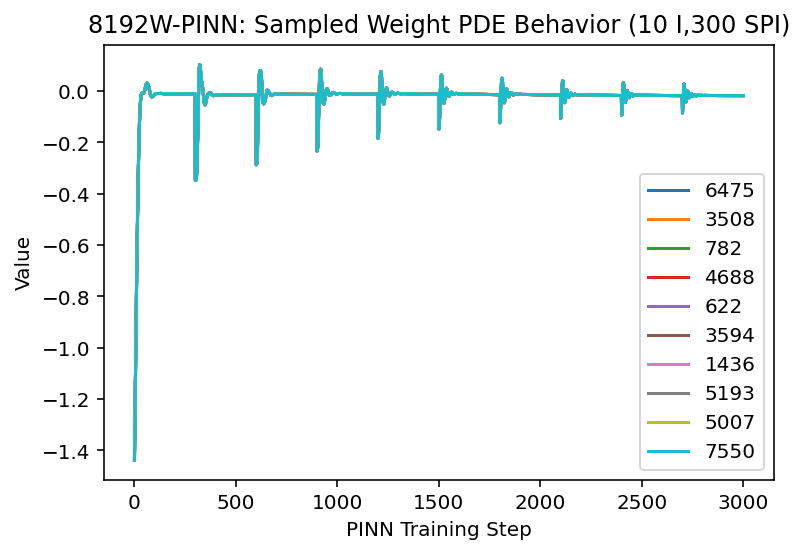

In [ ]:
# How do these results differ for different weights?

# choose random no. of weights
n_samples = 10

selected_function_progression = collectionWeightSample(f_collection,n_samples)
i = 0
for func in selected_function_progression[0]:
  plt.plot(func,label=selected_function_progression[1][i])
  i+=1
plt.xlabel('PINN Training Step')
plt.ylabel('Value')
plt.title(f'{len(f_collection[0])}W-PINN: Sampled Weight PDE Behavior ({10} I,{steps} SPI)')

plt.legend()
plt.show()